<a href="https://colab.research.google.com/github/ShaunakSen/Data-Science-and-Machine-Learning/blob/master/SmartSteelTech_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rough Approach

1. EDA
    - Explore how distribution of class labels change wrt each sensor
    - Corr bw sensor data
2. Baseline LogReg model
    - explore performance
    - wts of the features correspond to the importances?

3. Decision Tree model
    - feature importances

4. SHAP on that DT
    - Global Importances
    - Local Importances
    - if we have instances that are more imp to us, we can look that the
    - features which explain those instances and put more wt on these features; SHAP allows us to do this
    - Also imagine if our prob were unbalanced and there are few values of one class. Now one feature may only be imp in predictions of that class. The default FI calculates how many times a feature is used as a split and this no will be low for that feature, but its very imp for that class

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

%matplotlib inline

In [2]:
data = pd.read_csv(filepath_or_buffer='./smart_steel_data/task_data.csv')
data

,sample index,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,sample0,1.0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,sample1,1.0,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,sample2,1.0,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,sample3,1.0,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,sample4,1.0,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969
...,...,...,...,...,...,...,...,...,...,...,...,...
395,sample395,-1.0,0.433150,0.816109,0.452945,0.065469,0.237093,0.719321,0.577969,0.085598,0.357115,0.070060
396,sample396,-1.0,0.339346,0.914610,0.097827,0.077522,0.484140,0.690568,0.420054,0.482845,0.395148,0.438641
397,sample397,-1.0,0.320118,0.444951,0.401896,0.970993,0.960264,0.138345,0.354927,0.230749,0.204612,0.558889
398,sample398,-1.0,0.059132,0.337426,0.772847,0.099038,0.966042,0.975086,0.532891,0.035839,0.258723,0.709958


In [3]:
data.isnull().sum(axis=0)

sample index    0
class_label     0
sensor0         0
sensor1         0
sensor2         0
sensor3         0
sensor4         0
sensor5         0
sensor6         0
sensor7         0
sensor8         0
sensor9         0
dtype: int64

Good, so no NULL values

In [4]:
data.describe()

,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.000000,0.523661,0.509223,0.481238,0.509752,0.497875,0.501065,0.490480,0.482372,0.482822,0.541933
std,1.001252,0.268194,0.276878,0.287584,0.297712,0.288208,0.287634,0.289954,0.282714,0.296180,0.272490
min,-1.000000,0.007775,0.003865,0.004473,0.001466,0.000250,0.000425,0.000173,0.003322,0.003165,0.000452
25%,-1.000000,0.299792,0.283004,0.235544,0.262697,0.249369,0.269430,0.226687,0.242848,0.213626,0.321264
50%,0.000000,0.534906,0.507583,0.460241,0.510066,0.497842,0.497108,0.477341,0.463438,0.462251,0.578389
75%,1.000000,0.751887,0.727843,0.734937,0.768975,0.743401,0.738854,0.735304,0.732483,0.740542,0.768990
max,1.000000,0.999476,0.998680,0.992963,0.995119,0.999412,0.997367,0.997141,0.998230,0.996098,0.999465


All features are in rane 0 -> 1, so they are quite normalized

In [5]:
data['class_label'].value_counts()

-1.0    200
 1.0    200
Name: class_label, dtype: int64

This is a perfectly balanced binary classification scenario

## Analysis 1 : How does the distrubution of class label changes wrt each feature

- For each feature, how is the distribution of values for the class label
- pairwise boxplot with the 2 classes as 2 diff colors

In [18]:
def feature_distribution_per_class(data, features):
    """
    For each feature print out the distribution of that feature for each class
    """
    for fea_ in features:
        if fea_ in data.columns:
            display(data.groupby('class_label').aggregate({fea_: ['mean', min, max]} ))

    return

features = [f'sensor{i}' for i in range(10)]
feature_distribution_per_class(data, features)

sensor0                    
                 mean       min       max
class_label                              
-1.0         0.378135  0.007775  0.999476
 1.0         0.669187  0.017610  0.999476

sensor1                    
                 mean       min       max
class_label                              
-1.0         0.578911  0.004316  0.998680
 1.0         0.439535  0.003865  0.981556

sensor2                    
                 mean       min       max
class_label                              
-1.0         0.470101  0.004473  0.992963
 1.0         0.492376  0.013799  0.975777

sensor3                    
                 mean       min       max
class_label                              
-1.0         0.380815  0.001466  0.995119
 1.0         0.638689  0.014431  0.991156

sensor4                    
                 mean       min       max
class_label                              
-1.0         0.322972  0.000250  0.999412
 1.0         0.672778  0.002246  0.999412

sensor5                    
                 mean       min       max
class_label                              
-1.0         0.436673  0.000425  0.984338
 1.0         0.565457  0.002695  0.997367

sensor6                    
                 mean       min       max
class_label                              
-1.0         0.492627  0.248746  0.745404
 1.0         0.488333  0.000173  0.997141

sensor7                    
                 mean       min       max
class_label                              
-1.0         0.432786  0.003453  0.975558
 1.0         0.531957  0.003322  0.998230

sensor8                    
                 mean       min       max
class_label                              
-1.0         0.287406  0.003864  0.959601
 1.0         0.678239  0.003165  0.996098

sensor9                    
                 mean       min       max
class_label                              
-1.0         0.516104  0.007976  0.982287
 1.0         0.567762  0.000452  0.999465

At a glance there looks to be variability in all features for each class label

- For most features the avg value of that feature for class 1 is diffenet from that of class -1

- For sensor6, the mean is very similar, but again the min and max differ, so even this feature can be quite important

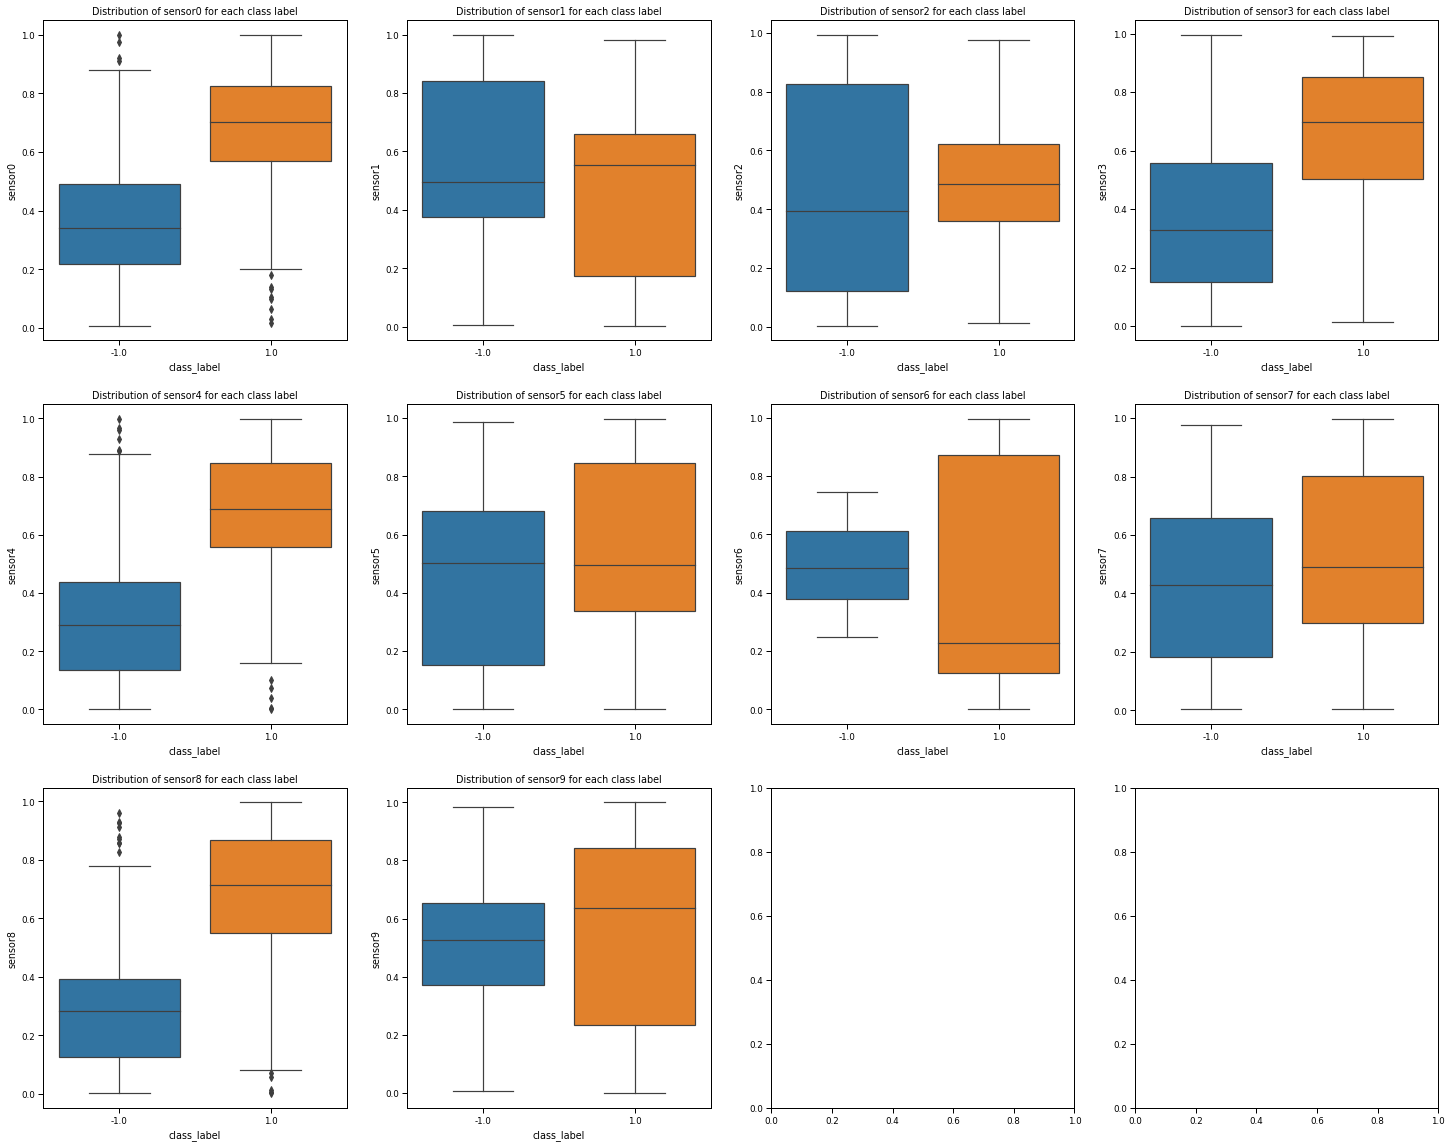

In [36]:
def plot_feature_distribution_per_class(data, features, ncols):
    """
    Plot the distribution for each feature wrt each label
    data: the input dataframe
    features: feature names to plot
    ncols: no of cols to use in the figure (rows get adjusted automatically)
    """
    fig, axes = plt.subplots(int(np.ceil(len(features)/ncols)), ncols, figsize=(25, 20))
    sns.set_context('paper')
    row_idx = -1
    for idx, fea_ in enumerate(features):
        if idx > ncols-1:
            col_idx = idx%ncols
        else:
            col_idx = idx
        if col_idx == 0:
            row_idx += 1
        sns.boxplot(ax=axes[row_idx, col_idx], x='class_label', y=fea_, data=data)
        axes[row_idx, col_idx].set_title(f'Distribution of {fea_} for each class label')

    return


plot_feature_distribution_per_class(data, features, 4)

- we can see from the plots as well that the distributions differ significantly within classes for each of the features
- from this, we conclude that __we cannot yet assume that any feature is not important__